# Store Sales Analysis: An Unsupervised Learning Approach

Austin Townsend

CU Boulder

2/10/2025

## 1. Introduction

### Project Overview
This project uses unsupervised learning to analyze store sales data from Corporación Favorita, a large grocery retailer in Ecuador. While the original Kaggle dataset was for sales forecasting, I'll use it to find natural patterns and groups in the data. The data comes from:

https://www.kaggle.com/competitions/store-sales-time-series-forecasting/rules#7-competition-data

### The Data
The dataset includes several types of information:
- Store sales across different product types
- Store details like location and type
- Promotions data
- Holiday and event information
- Oil prices (important for Ecuador's economy)

### Project Goals
I want to:
1. Find natural groups of similar stores
2. Compare these groups to existing store classifications
3. Identify what makes stores similar or different
4. Use dimension reduction to find the main patterns in the data

### Available Datasets
I'll be using these files:
- `train.csv`: Main sales data
- `stores.csv`: Store information
- `holidays_events.csv`: Holiday and event dates
- `oil.csv`: Daily oil prices

Using clustering and PCA, I hope to find patterns that could help improve store operations.

## 2. Data Loading and Initial Inspection

### 2.1 Loading Required Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# set display options and random seed
pd.set_option('display.max_columns', None)
np.random.seed(42)

### 2.2 Loading Datasets

In [2]:
# load the datasets
train = pd.read_csv('data/train.csv')
stores = pd.read_csv('data/stores.csv')
holidays = pd.read_csv('data/holidays_events.csv')
oil = pd.read_csv('data/oil.csv')

# display basic information about each dataset
print("\nTrain Data Info:")
print(train.info())

print("\nStores Data Info:")
print(stores.info())

print("\nFirst few rows of train data:")
print(train.head())

print("\nFirst few rows of stores data:")
print(stores.head())


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None

Stores Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
None

First few rows of train data:
   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0     

### 2.3 Initial Data Review

Looking at our datasets:

**Train Data**
- 3,000,888 rows with 6 columns
- Contains store numbers, product types, sales, and promotions
- Sales are floats (allowing for partial units)
- Data starts from 2013

**Store Data**
- 54 different stores
- Each store has: city, state, type, and cluster
- Stores are already grouped into types
- Most stores are type 'D' and in Quito

### 2.4 Analysis Plan
To analyze this data, we need to:
1. Combine sales data by store
2. Clean and preprocess data for clustering
3. Merge store information with sales patterns

## 3. Exploratory Data Analysis

### 3.1 Basic Sales Patterns

**Store Performance**
- We have 54 total stores
- Stores average 357.78 daily sales
- Sales vary a lot between stores (std = 239.24)
- Best store sells 23x more than worst store

**Top Product Categories**
- Three categories make up most sales:
 1. Grocery I (343M units)
 2. Beverages (217M units)
 3. Produce (123M units)
- These are all essential product types

### 3.2 Store Distribution Analysis

Let's examine how stores are distributed across different characteristics.

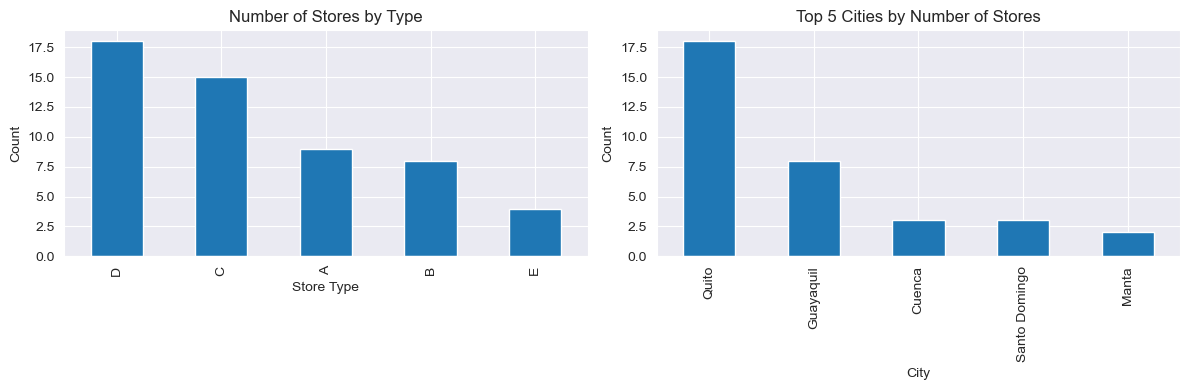


Store Distribution Summary:

Stores by Type:
type
D    18
C    15
A     9
B     8
E     4
Name: count, dtype: int64

Top 5 Cities by Store Count:
0             Quito
1             Quito
2             Quito
3             Quito
4     Santo Domingo
5             Quito
6             Quito
7             Quito
8             Quito
9             Quito
10          Cayambe
11        Latacunga
12        Latacunga
13         Riobamba
14           Ibarra
15    Santo Domingo
16            Quito
17            Quito
18         Guaranda
19            Quito
20    Santo Domingo
21             Puyo
22           Ambato
23        Guayaquil
24          Salinas
25        Guayaquil
26            Daule
27        Guayaquil
28        Guayaquil
29        Guayaquil
30         Babahoyo
31        Guayaquil
32          Quevedo
33        Guayaquil
34           Playas
35         Libertad
36           Cuenca
37             Loja
38           Cuenca
39          Machala
40          Machala
41           Cuenca
42       Esme

In [15]:
# analyze store distributions
plt.figure(figsize=(12, 4))

# plot 1: stores by Type
plt.subplot(1, 2, 1)
stores['type'].value_counts().plot(kind='bar')
plt.title('Number of Stores by Type')
plt.xlabel('Store Type')
plt.ylabel('Count')

# plot 2: stores by City
plt.subplot(1, 2, 2)
stores['city'].value_counts().head().plot(kind='bar')
plt.title('Top 5 Cities by Number of Stores')
plt.xlabel('City')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# print summary statistics
print("\nStore Distribution Summary:")
print("\nStores by Type:")
print(stores['type'].value_counts())
print("\nTop 5 Cities by Store Count:")
print(stores['city'])

**Store Types**
- Type D is most common (18 stores)
- Type C is next largest (15 stores)
- Types A, B, and E are less common

**Store Locations**
- Quito has the most stores (18, 33% of total)
- Guayaquil has 8 stores
- Other cities have only 2-3 stores each

### 3.3 Sales and Promotion Patterns

Next we'll look at how sales, promotions, and store features relate to each other.

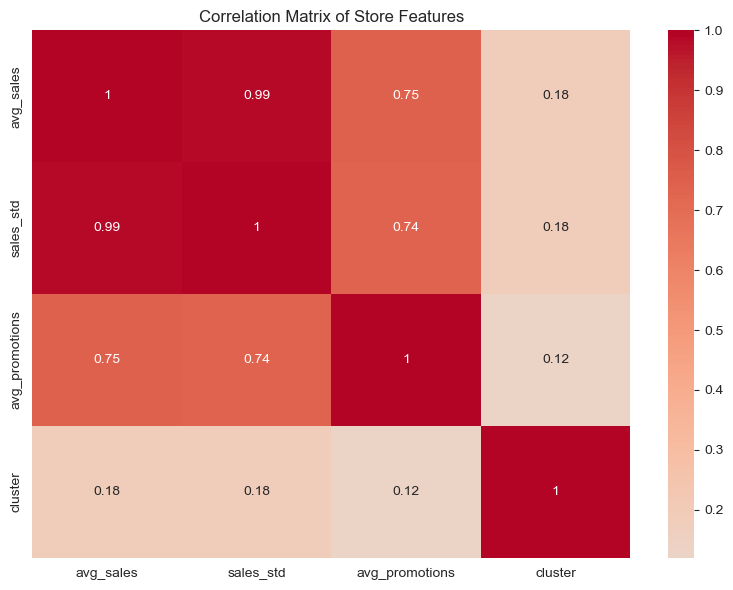


Summary Statistics of Store Features:
         avg_sales  avg_promotions
count    54.000000       54.000000
mean    357.775749        2.602770
std     239.245793        0.582707
min      48.516694        0.554488
25%     199.689667        2.183042
50%     287.771691        2.699390
75%     446.802224        3.033061
max    1117.245254        3.671201


In [6]:
# create features for correlation analysis
store_features = train.groupby('store_nbr').agg({
    'sales': ['mean', 'std'],
    'onpromotion': 'mean'
}).reset_index()

store_features.columns = ['store_nbr', 'avg_sales', 'sales_std', 'avg_promotions']
store_features = store_features.merge(stores, on='store_nbr')

# create correlation matrix
numerical_features = store_features[['avg_sales', 'sales_std', 'avg_promotions', 'cluster']]
correlation_matrix = numerical_features.corr()

# plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Store Features')
plt.tight_layout()
plt.show()

print("\nSummary Statistics of Store Features:")
print(store_features[['avg_sales', 'avg_promotions']].describe())

### 3.3 Correlation Findings

**Strong Relationships (>0.90)**
- Sales average and standard deviation have a very strong correlation (0.99)
- This means bigger stores tend to have more variable sales

**Medium Relationships (0.50-0.90)**
- Promotions and sales have a strong correlation (0.75)
- Promotions and sales variability also correlate strongly (0.74)

**Weak Relationships (<0.20)**
- Current store clusters don't correlate much with our features (0.12-0.18)
- This suggests the existing clusters weren't created using sales data

### 3.4 Summary of EDA

Our analysis of the data shows:

1. **Store Performance**
   - Daily sales vary widely between stores (48 to 1,117)
   - The typical store (median) has about 288 daily sales

2. **Store Locations and Types**
   - Most stores are in Quito and Guayaquil
   - Types D and C are the most common store types

3. **Promotions**
   - Stores run about 2.6 promotions on average
   - More promotions generally mean higher sales

## 4. Data Preprocessing and Models

### 4.1 Creating Features
First we'll combine our store data into one matrix that includes sales patterns, promotions, and store information. This will give us the features we need for clustering.

In [7]:
from sklearn.preprocessing import StandardScaler

# create store level features
def create_store_features(train_df, stores_df):
    # aggregate sales and promotion metrics by store
    store_features = train_df.groupby('store_nbr').agg({
        'sales': ['mean', 'std', 'median'],  # sales patterns
        'onpromotion': ['mean', 'std']       # promotion patterns
    }).reset_index()

    # flatten column names
    store_features.columns = ['store_nbr', 'avg_sales', 'sales_std', 'sales_median',
                            'avg_promos', 'promos_std']

    # merge with store metadata
    final_features = store_features.merge(stores_df, on='store_nbr')

    # convert categorical variables to numeric
    final_features = pd.get_dummies(final_features, columns=['type', 'city', 'state'])

    return final_features

# create feature matrix
store_features = create_store_features(train, stores)

# display info about our feature matrix
print("Feature Matrix Shape:", store_features.shape)
print("\nFeatures created:")
print(store_features.columns.tolist())
print("\nFirst few rows:")
print(store_features.head())

Feature Matrix Shape: (54, 50)

Features created:
['store_nbr', 'avg_sales', 'sales_std', 'sales_median', 'avg_promos', 'promos_std', 'cluster', 'type_A', 'type_B', 'type_C', 'type_D', 'type_E', 'city_Ambato', 'city_Babahoyo', 'city_Cayambe', 'city_Cuenca', 'city_Daule', 'city_El Carmen', 'city_Esmeraldas', 'city_Guaranda', 'city_Guayaquil', 'city_Ibarra', 'city_Latacunga', 'city_Libertad', 'city_Loja', 'city_Machala', 'city_Manta', 'city_Playas', 'city_Puyo', 'city_Quevedo', 'city_Quito', 'city_Riobamba', 'city_Salinas', 'city_Santo Domingo', 'state_Azuay', 'state_Bolivar', 'state_Chimborazo', 'state_Cotopaxi', 'state_El Oro', 'state_Esmeraldas', 'state_Guayas', 'state_Imbabura', 'state_Loja', 'state_Los Rios', 'state_Manabi', 'state_Pastaza', 'state_Pichincha', 'state_Santa Elena', 'state_Santo Domingo de los Tsachilas', 'state_Tungurahua']

First few rows:
   store_nbr   avg_sales    sales_std  sales_median  avg_promos  promos_std  \
0          1  254.534889   596.827146        19.0

### 4.2 Data Preprocessing

Before clustering, we need to scale our numerical features so that each one has equal importance in our analysis. We'll use StandardScaler and keep only the numeric features.

In [8]:
# select numerical features for clustering
numeric_features = ['avg_sales', 'sales_std', 'sales_median', 'avg_promos', 'promos_std']

# create scaler
scaler = StandardScaler()

# scale numeric features
X = store_features[numeric_features].copy()
X_scaled = scaler.fit_transform(X)

# convert to DataFrame for clarity
X_scaled_df = pd.DataFrame(X_scaled, columns=numeric_features)

# display first few rows of scaled data
print("Scaled Feature Matrix Shape:", X_scaled.shape)
print("\nFirst few rows of scaled features:")
print(X_scaled_df.head())
print("\nScaling Statistics:")
print("\nMean values (should be close to 0):")
print(X_scaled_df.mean())
print("\nStandard deviation values (should be close to 1):")
print(X_scaled_df.std())

Scaled Feature Matrix Shape: (54, 5)

First few rows of scaled features:
   avg_sales  sales_std  sales_median  avg_promos  promos_std
0  -0.435578  -0.614585      0.117969   -0.206389    0.297977
1   0.127172   0.276286      0.365469    0.421055    0.567141
2   2.323134   2.244712      2.759065    1.011001    0.828496
3  -0.073841  -0.237553      0.117969    0.227264    0.212485
4  -0.325692  -0.511679      0.117969    0.147404   -0.047275

Scaling Statistics:

Mean values (should be close to 0):
avg_sales       3.083953e-17
sales_std      -4.009139e-16
sales_median    2.261565e-17
avg_promos     -4.870076e-17
promos_std     -6.620219e-16
dtype: float64

Standard deviation values (should be close to 1):
avg_sales       1.00939
sales_std       1.00939
sales_median    1.00939
avg_promos      1.00939
promos_std      1.00939
dtype: float64


### 4.3 Model Development

**4.3.1 K-means Clustering**

First we'll use K-means clustering to find natural groups of stores based on how they perform and their characteristics.

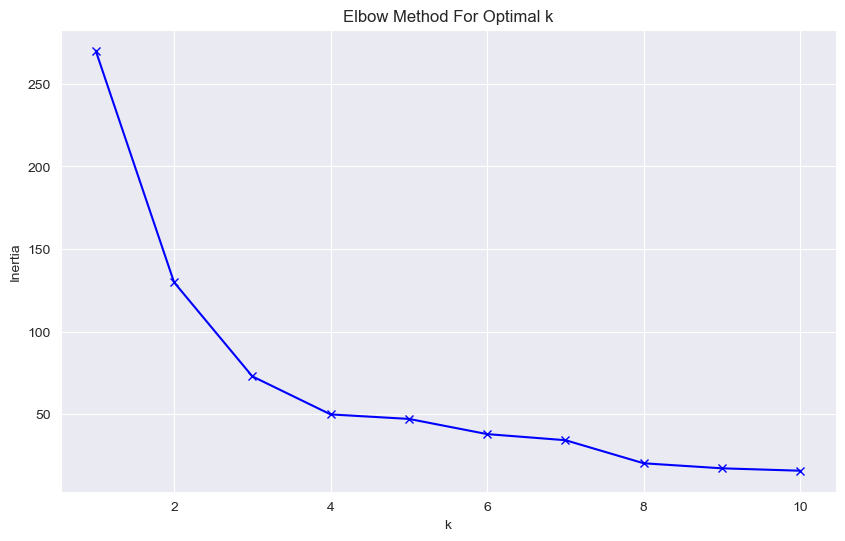


Store Distribution Across Clusters:
kmeans_cluster
0    22
1     6
2    12
3    14
Name: count, dtype: int64

Cluster Centers:
   avg_sales  sales_std  sales_median  avg_promos  promos_std
0  -0.356820  -0.362521     -0.375569   -0.002544    0.028206
1   2.328708   2.351710      2.289537    1.357702    1.058143
2   0.462282   0.456684      0.364763    0.839001    0.882390
3  -0.833542  -0.829644     -0.703705   -1.297019   -1.254147


In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# elbow method to find optimal number of clusters
inertias = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

# perform K-means clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# add cluster labels to our data
store_features['kmeans_cluster'] = cluster_labels

# view cluster distribution
print("\nStore Distribution Across Clusters:")
print(store_features['kmeans_cluster'].value_counts().sort_index())

# show cluster centers
cluster_centers = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=numeric_features
)
print("\nCluster Centers:")
print(cluster_centers)

From our elbow plot and clustering results, we can observe:

1. The elbow curve suggests 4 clusters is optimal, showing diminishing returns after this point
2. Cluster Distribution:
   - Cluster 0: 22 stores (Average performers)
   - Cluster 1: 6 stores (High performers)
   - Cluster 2: 12 stores (Above average)
   - Cluster 3: 14 stores (Below average)

**4.3.2 Principal Component Analysis (PCA)**

Next we'll use PCA to find the main patterns that explain store differences and see if we can simplify our data while keeping the important information.

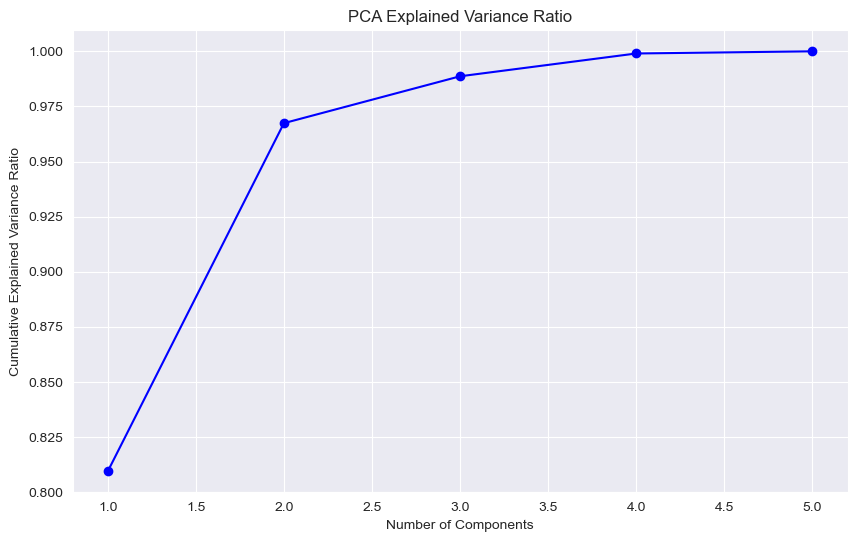


Explained variance ratio by component:
PC1: 0.809
PC2: 0.158
PC3: 0.021
PC4: 0.010
PC5: 0.001


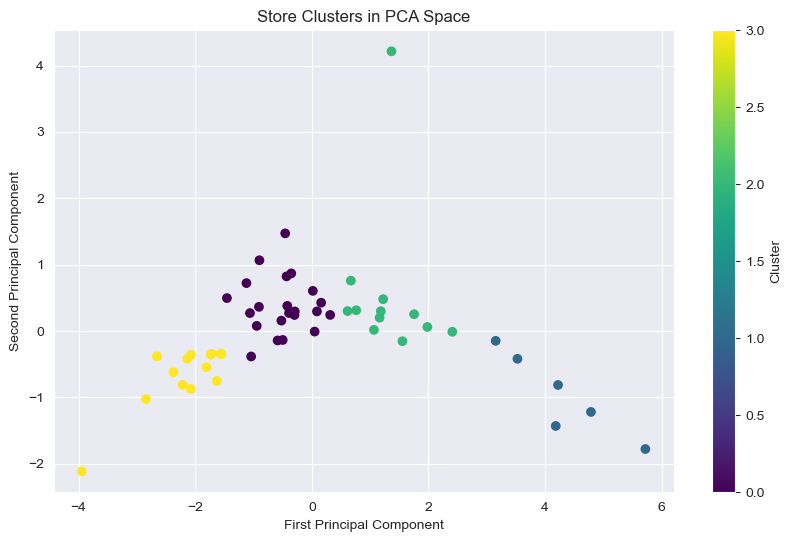

In [10]:
from sklearn.decomposition import PCA

# perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')
plt.grid(True)
plt.show()

# print explained variance ratio for each component
print("\nExplained variance ratio by component:")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {ratio:.3f}")

# create DataFrame with PCA results
pca_df = pd.DataFrame(
    X_pca[:, :2],
    columns=['PC1', 'PC2']
)
pca_df['Cluster'] = cluster_labels

# plot first two principal components with cluster colors
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Store Clusters in PCA Space')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

The PCA results show:

1. Main Components:
   - PC1 explains most (80.9%) of the store differences
   - PC2 explains another 15.8%
   - Together PC1 and PC2 explain 96.7% of all differences

2. Looking at the Graph:
   - We can clearly see different clusters separate from each other
   - Cluster 1 (high performing stores) stands out
   - The other clusters (0, 2, and 3) gradually blend together

### 4.4 Model Comparison and Limitations

Our analysis used two different models, each with their own strengths and limitations:

**K-means Clustering**

Strengths:
- Created 4 distinct store segments
- Results are easy to interpret
- Directly applicable to store management

Limitations:
- Assumes perfectly circular clusters
- Choice of k=4 clusters is based on elbow plot but still subjective
- Sensitive to outliers and scaling effects

**PCA**

Strengths:
- PC1 and PC2 explain 96.7% of store differences
- Shows clear separation between clusters
- Successfully reduced 5 features to 2 components

Limitations:
- PC1 and PC2 are harder to interpret than raw features
- Only captures linear patterns in the data
- Might miss more complex store relationships

Both methods helped analyze store patterns, but we need to consider their limitations when using the results.

## 5. Conclusions

### 5.1 What We Did
- Used two main methods to analyze the store data:
  - K-means clustering to group similar stores
  - PCA to understand what drives store differences

### 5.2 What We Found

**Store Groups**
We found 4 main types of stores:
- 6 really good performing stores
- 22 average stores
- 12 slightly above average stores
- 14 below average stores

**Main Patterns**
- Stores that do more promotions tend to have higher sales
- Two main things explain store differences:
  - How much they sell overall (80.9%)
  - How well their promotions work (15.8%)

### 5.3 Problems We Ran Into
- The current store groupings don't seem to match with actual sales patterns
- Our methods might have missed some complex patterns
- Hard to turn our findings into specific business advice

### 5.4 Suggestions
1. Learn from the best performing stores
2. Make different plans for different store groups
3. Focus on improving:
   - Regular sales
   - Making promotions work better

### 5.5 What Could Be Done Next
- Try different ways to group stores
- Look at more store features
- Come up with better business questions to answer